In [10]:
# CELL-1: loading, preprocessing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../ArewaDS-Machine-Learning-Assignments/week4/US-pumpkins.csv')
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

#Taking the average price and convertin date to month
price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2
month = pd.DatetimeIndex(pumpkins['Date']).month

#converting month to days of the year
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

#Dataframe of the required columns
new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,DayOfYear,Variety,City,Package,Low Price,High Price,Price
70,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,267,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,274,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,281,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


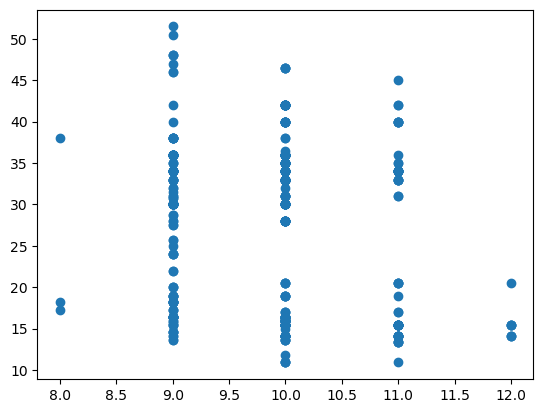

In [11]:
# CELL-2: visualized processed dataframe
plt.scatter('Month','Price',data=new_pumpkins)

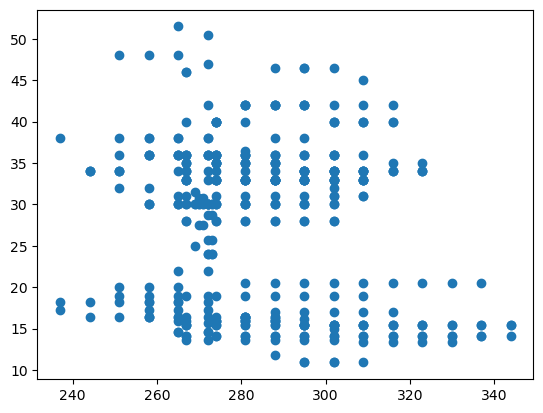

In [13]:
# CELL-3: Visualisation after applying more fine-grained, day of the year is used intead of month
plt.scatter('DayOfYear','Price',data=new_pumpkins)

Let's find out if there is any correlation btween the price and time date using the corr function:

In [14]:
#CELL-4: determine the correlation betweem the price and month and day of years as well
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Categrised the pumpkins based on variety

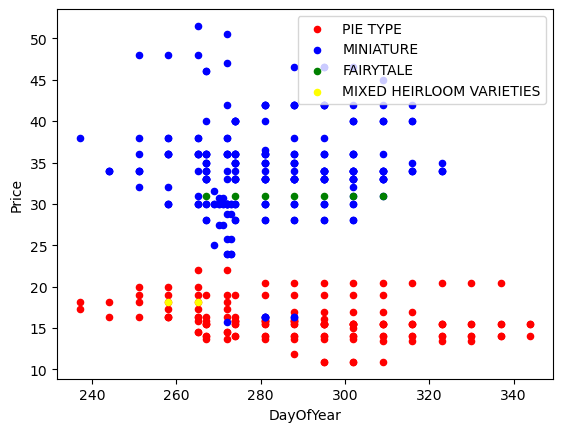

In [26]:
#CELL-5: Visualization by Categrising variety
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety']==var]
    ax = df.plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

Further iInvestigation of relationship the variety and price using density plot

<Axes: ylabel='Density'>

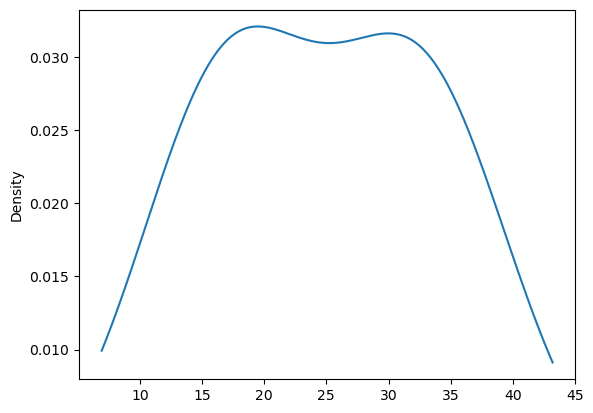

In [17]:
#CELL-6
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='density')

<Axes: xlabel='DayOfYear', ylabel='Price'>

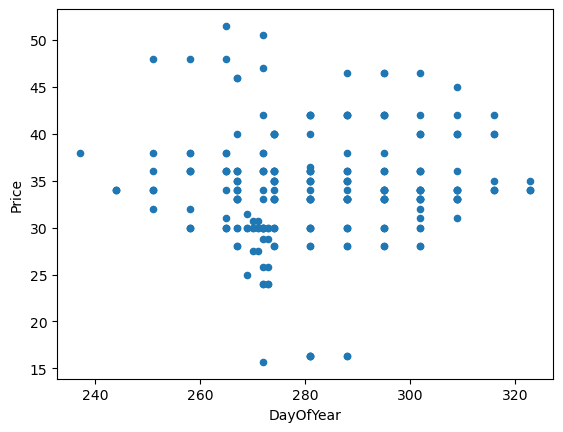

In [28]:
#CELL-6: Cosidering Only Pie type
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='MINIATURE']
pie_pumpkins.plot.scatter('DayOfYear','Price') 

# Simple Linear Regression

Model development on

Mean error: 5.31 (15.7%)
Model determination:  0.0024258084621505693


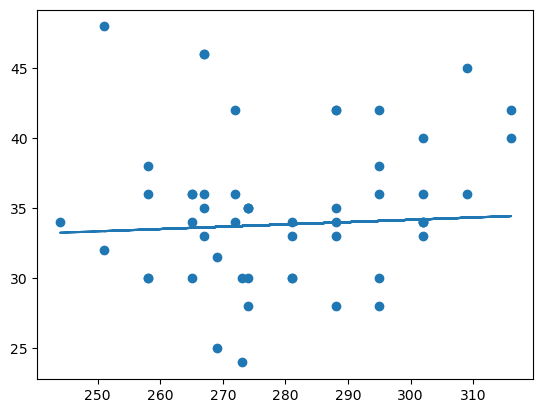

In [29]:
#CELL- 7: Developing Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Mean error: 5.17 (15.2%)
Model determination:  0.01754220848578758


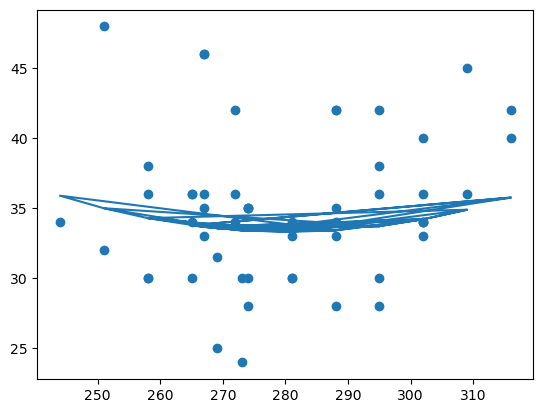

In [32]:
#CELL-8: Developing polynormial model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#To include all second-degree polynomials from the input data.
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(X_test, pred)



Encoding for categorical data

In [33]:
pd.get_dummies(new_pumpkins['Variety'])

,FAIRYTALE,MINIATURE,MIXED HEIRLOOM VARIETIES,PIE TYPE
70,0,0,0,1
71,0,0,0,1
72,0,0,0,1
73,0,0,0,1
74,0,0,0,1
...,...,...,...,...
1738,0,1,0,0
1739,0,1,0,0
1740,0,1,0,0
1741,0,1,0,0


#Encoding non-numeric value

In [36]:
#CELL-9: Puting all together for encoding

# set up training data
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# setup and train the pipeline
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)


Mean error: 2.23 (8.25%)
Model determination:  0.9652869939759445
